In [1]:
import time
import json
from dataclasses import dataclass
import torch
from PIL import Image, ImageDraw
import onnxruntime
from transformers import RTDetrImageProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class DetrOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

In [2]:
image_processor = RTDetrImageProcessor.from_pretrained("jadechoghari/RT-DETRv2")
image_processor.size = {'height': 480, 'width': 640}

In [3]:
with open('../../assets/labels.txt', 'r') as f:
    labels = json.loads(f.read())

In [4]:
ort_session = onnxruntime.InferenceSession("../../model.onnx", providers=["CUDAExecutionProvider"])
# ort_session = onnxruntime.InferenceSession("../../model.onnx", providers=["CPUExecutionProvider"])

In [8]:
img = Image.open("../../assets/000000039769.jpg")

start = time.time()
input_tensor = image_processor(img, return_tensors="pt").to(device)
end = time.time()
print(f"image processor (pre): {end - start}")

start = time.time()
ort_inputs = {'images': input_tensor["pixel_values"].cpu().numpy()}
ort_outs = ort_session.run(
    output_names=None, 
    input_feed=ort_inputs
)
end = time.time()
print(f"model: {end - start}")

start = time.time()
detr_output = DetrOutput(logits = torch.from_numpy(ort_outs[0]).to("cuda"),
                         pred_boxes = torch.from_numpy(ort_outs[1]).to("cuda"))
results = image_processor.post_process_object_detection(detr_output, target_sizes=torch.tensor([img.size[::-1]]), threshold=0.3)
end = time.time()
print(f"image processor (post): {end - start}")

image processor (pre): 0.007562160491943359
model: 0.022537946701049805
image processor (post): 0.0010023117065429688


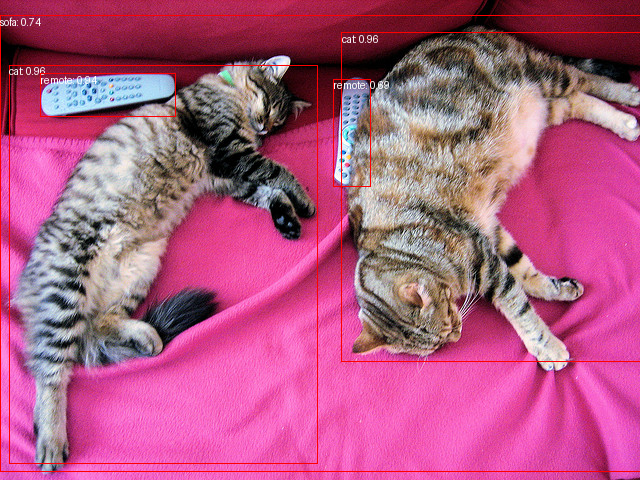

In [9]:
draw_img = img.copy()
draw = ImageDraw.Draw(draw_img)

for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        score, label = score.item(), label_id.item()
        box = [round(i, 2) for i in box.tolist()]
        if score > 0.5:
            draw.rectangle(box, fill=None, outline='red')
            draw.text((box[0], box[1]), f"{labels[str(label)]}: {score:.2f}")

display(draw_img)